I recently got asked about my work in radio communications, so I thought I'd recap what an FM signal is, and how you demodulate them.

#### Signals

The simplest signal is a sine wave, and below is a sin wave of 1 second duration sampled at 300Hz (this will be our baseband signal):

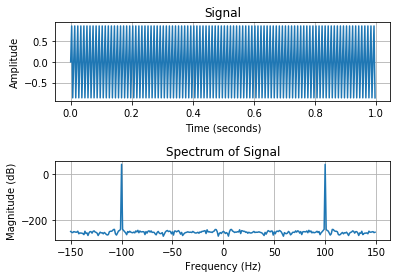

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

t_sim = 1
fs = 300
x = np.arange(0,t_sim,1/fs)

y = np.sin(2*np.pi*100*x)

yf = 20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(y))))

xf = np.arange(-1/(2*t_sim)*y.size, 1/(2*t_sim)*y.size, 1/(t_sim))

fig = plt.figure()
fig.subplots_adjust(hspace = 0.75)
ax1 = fig.add_subplot(211) # 211 means, 2-by-1 grid, select plot 1
ax1.plot(x,y)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Signal')
ax1.grid(True)
ax2 = fig.add_subplot(212) # 212 means, 2-by-1 grid, select plot 2
ax2.plot(xf, yf)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Spectrum of Signal')
ax2.grid(True)

Frequency modulation is implemented in the following function:

In [4]:
# def FMmod(sample_rate, carrier_frequency, modulation_freqeuncy, modulation_index):

#     fm_integral = 0
    
#     t = []
#     fm = []

#     for i in range(int(sample_rate)):
#         dt = i/sample_rate 
#         mod_sig = cos(2*pi*modulation_frequency*dt)
#         fm_integral += mod_sig* modulation_index / sample_rate
#         dfm = cos(2*pi*carrier_frequency*(dt+fm_integral))
#         t.append(dt)
#         fm.append(dfm)
#     return t, fm

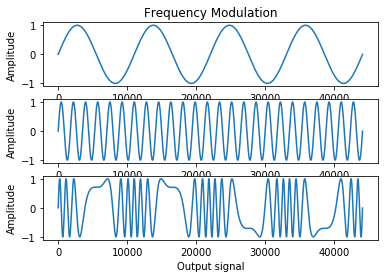

In [76]:
modulator_frequency = 4.0
carrier_frequency = 25.0
modulation_index = 1.0

time = np.arange(44100.0) / 44100.0
modulator = np.sin(2.0 * np.pi * modulator_frequency * time) * modulation_index
carrier = np.sin(2.0 * np.pi * carrier_frequency * time)
product = np.zeros_like(modulator)

for i, t in enumerate(time):
    product[i] = np.sin(2. * np.pi * (carrier_frequency * t + modulator[i]))

plt.subplot(3, 1, 1)
plt.title('Frequency Modulation')
plt.plot(modulator)
plt.ylabel('Amplitude')
plt.xlabel('Modulator signal')
plt.subplot(3, 1, 2)
plt.plot(carrier)
plt.ylabel('Amplitude')
plt.xlabel('Carrier signal')
plt.subplot(3, 1, 3)
plt.plot(product)
plt.ylabel('Amplitude')
plt.xlabel('Output signal')
plt.show()

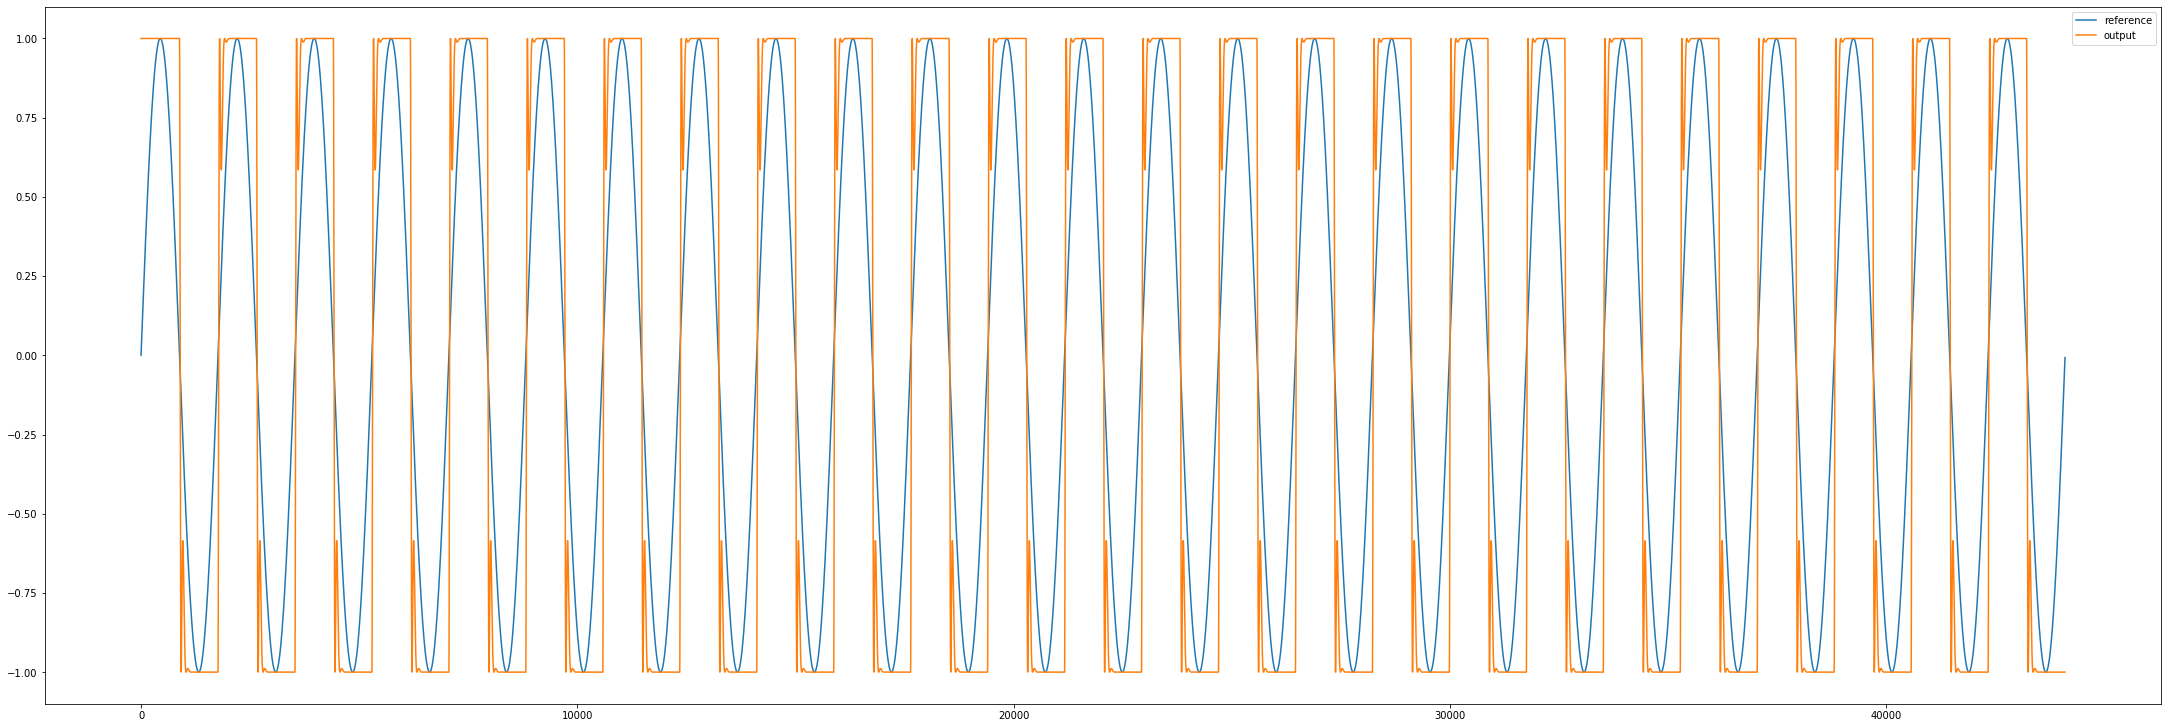

In [77]:
class SimPLL(object):
    def __init__(self, lf_bandwidth):
        self.phase_out = 0.0
        self.freq_out = 0.0
        self.vco = np.exp(1j*self.phase_out)
        self.phase_difference = 0.0
        self.bw = lf_bandwidth
        self.beta = np.sqrt(lf_bandwidth)

    def update_phase_estimate(self):
        self.vco = np.exp(1j*self.phase_out)

    def update_phase_difference(self, in_sig):
        self.phase_difference = np.angle(in_sig*np.conj(self.vco))

    def step(self, in_sig):
        # Takes an instantaneous sample of a signal and updates the PLL's inner state
        self.update_phase_difference(in_sig)
        self.freq_out += self.bw * self.phase_difference
        self.phase_out += self.beta * self.phase_difference + self.freq_out
        self.update_phase_estimate()
        
pll = SimPLL(0.001)
num_samples = time.shape[0]
ref = []
out = []
diff = []
for i in range(0, num_samples - 1):
    in_sig = carrier[i]
    pll.step(in_sig)
    ref.append(in_sig)
    out.append(pll.vco)
    diff.append(pll.phase_difference)

fig = plt.figure(constrained_layout=True, figsize=(30, 10))
plt.plot(ref)
plt.plot(out)
# plt.plot(diff)
plt.legend(['reference', 'output'])

/Users/thomas.kealy/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


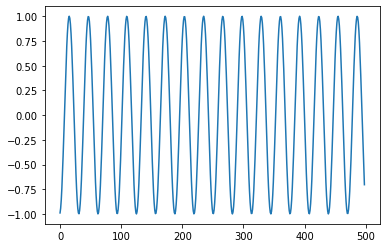

In [74]:
plt.plot(phil)

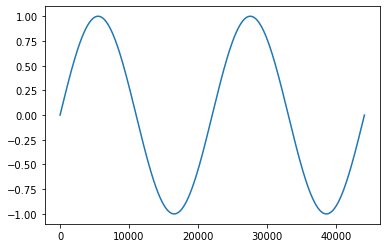

In [75]:
plt.plot(carrier)

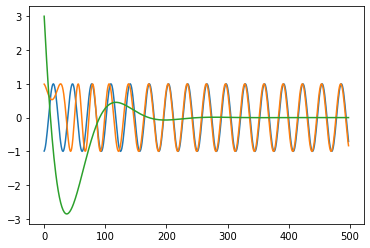

In [68]:
pll = SimPLL(0.002)
num_samples = 500
phi = 3.0
frequency_offset = -0.2
ref = []
out = []
diff = []
phil = []
for i in range(0, num_samples - 1):
    in_sig = np.exp(1j*phi)
    phil.append(in_sig)
    phi += frequency_offset
    pll.step(in_sig)
    ref.append(in_sig)
    out.append(pll.vco)
    diff.append(pll.phase_difference)
plt.plot(ref)
plt.plot(out)
plt.plot(diff)

In [29]:
class LoopFilter(object):
    def __init__(self, gain, bandwidth, damping):
        self.a1 = -2.0
        self.a2 = 1.0
        t1 = gain/(bandwidth*bandwidth)
        t2 = (2*damping)/bandwidth
        self.b0 = (4*gain/t1)*(1.0+t2/2.0)
        self.b1 = (8*gain)/t1
        self.b2 = (4*gain/t1)*(1.0-t2/2.0)
        self.v0 = 0.0
        self.v1 = 0.0
        self.v2 = 0.0
        self.output = 0.0
        
    def advance_filter(self, phase_difference):
        self.v2 = self.v1
        self.v1 = self.v0
        self.v0 = (phase_difference - self.v1*self.a1 - self.v2*self.a2)

    def new_output(self):
        return self.v0*self.b0 + self.v1*self.b1 + self.v2*self.b2


class PLL(object):
    def __init__(self, lf_gain, lf_bandwidth, lf_damping):
        self.phase_estimate = 0.0
        self.vco = np.exp(1j*self.phase_estimate)
        self.phase_difference = 0.0
        self.loop_filter = LoopFilter(lf_gain, lf_bandwidth, lf_damping)
        
    def update_phase_estimate(self):
        self.phase_estimate = self.loop_filter.new_output()
        self.vco = np.exp(1j*self.phase_estimate)

    def update_phase_difference(self, in_sig):
        self.phase_difference = np.angle(in_sig*np.conj(self.vco))

    def step(self, in_sig):
        # Takes an instantaneous sample of a signal and updates the PLL's inner state
        self.update_phase_difference(in_sig)
        self.loop_filter.advance_filter(self.phase_difference)
        self.update_phase_estimate()

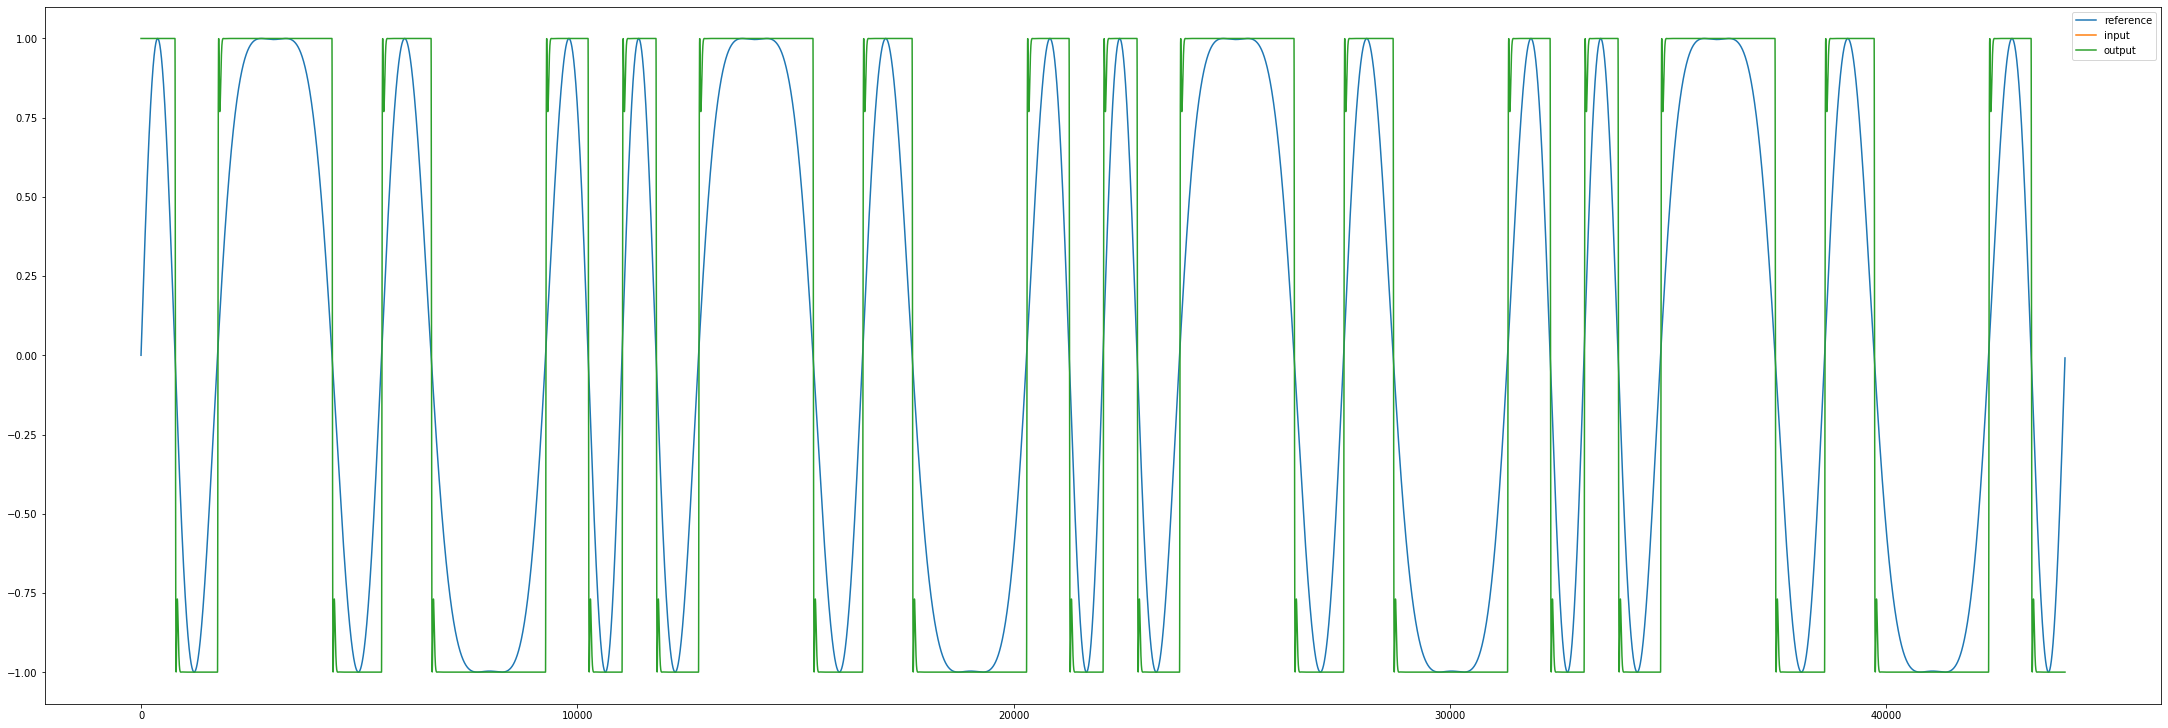

In [54]:
pll = PLL(0.00000001, 0.01, 0.707)
num_samples = time.shape[0]
frequency_offset = .1
ref = []
out = []
diff = []
for i in range(0, num_samples - 1):
    in_sig = product[i]
    pll.step(in_sig)
    ref.append(in_sig)
    out.append(pll.vco)
    diff.append(pll.phase_difference)
    
fig = plt.figure(constrained_layout=True, figsize=(30, 10))
plt.plot(ref)
plt.plot(in_sig)
plt.plot(out)
#plt.plot(diff)
plt.legend(['reference', 'input', 'output'])